In [1]:
%matplotlib inline
import math
import os
from itertools import count, groupby
from operator import itemgetter

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.distributions import Bernoulli, Normal
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from pytorch_lightning import LightningModule, Trainer

from misc_util import *

In [23]:
# Model Visualization
with torch.no_grad():
    digits = get_digit_samples()
    swp = torch.linspace(-3, 3, steps=10)
    
@torch.no_grad()
def plot_digits(model, i=0):
    enc, *_  = model(digits)
    recons = sweep_variable_across_samples(model, enc.clone(), i, swp)
    plot_sweep_grid(digits.numpy(), recons, swp)

In [3]:
class MnistBetaTCVAE(LightningModule):
    def __init__(self, lr=0.001, beta=1.0, lamb=0.0, small=False):
        super().__init__()
        self.beta = beta
        self.lamb = lamb
        self.lr = lr
        
        self.z_dim = 20

        if small:
            # Newer Model Architecture
            self.encoder = nn.Sequential(nn.Linear(784, 400),
                                         nn.ReLU(),
                                         nn.Linear(400, 100),
                                         nn.ReLU())
            self.z_loc = nn.Linear(100, 20)
            self.z_scale = nn.Linear(100, 20)
            self.decoder = nn.Sequential(nn.Linear(20, 100),
                                         nn.ReLU(),
                                         nn.Linear(100, 400),
                                         nn.ReLU())
            self.x_loc = nn.Linear(400, 784)
            self.x_scale = nn.Linear(400, 784)

        else:
            # Older model architecture
            self.encoder = nn.Sequential(nn.Linear(784, 400),
                                         nn.ReLU(),
                                         nn.Linear(400, 200),
                                         nn.ReLU(),
                                         nn.Linear(200, 100),
                                         nn.ReLU())
            self.z_loc = nn.Linear(100, 20)
            self.z_scale = nn.Linear(100, 20)
            self.decoder = nn.Sequential(nn.Linear(20, 100),
                                         nn.ReLU(),
                                         nn.Linear(100, 200),
                                         nn.ReLU(),
                                         nn.Linear(200, 400),
                                         nn.ReLU(),
                                         nn.Linear(400, 784),
                                         nn.ReLU())
            self.x_loc = nn.Linear(784, 784)
            self.x_scale = nn.Linear(784, 784)
        
    def prepare_data(self):
        MNIST(os.getcwd(), train=True, download=True)

    def train_dataloader(self):
        data = MNIST(os.getcwd(), transform=ToTensor())
        return DataLoader(data, batch_size=128)
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.lr)
    
    def encode(self, x):
        h = self.encoder(x)
        z_mu = self.z_loc(h)
        z_std = 1e-6 + F.softplus(self.z_scale(h))
        return z_mu, z_std
    
    def decode(self, z):
        h = self.decoder(z)
        x_mu = self.x_loc(h)
        x_std = 1e-6 + F.softplus(self.x_scale(h))
        return x_mu, x_std
    
    def forward(self, x):
        z_mu, z_std = self.encode(x)
        z = z_mu + z_std*torch.randn_like(z_std)
        x_mu, x_std = self.decode(z)
        return z, z_mu, z_std, x, x_mu, x_std

    def elbo_loss(self, x):
        x_len = x.shape[0]
        z, z_mu, z_std, _, x_mu, x_std = self.forward(x)

        # log(p(x))
        xdist = Normal(x_mu, x_std)
        logpx = xdist.log_prob(x).view(x_len, -1).sum(1)

        # log(p(z))
        pdist = Normal(torch.zeros_like(z), torch.ones_like(z))
        logpz = pdist.log_prob(z).view(x_len, -1).sum(1)

        # log(q(z|x))
        qdist = Normal(z_mu, z_std)
        logqz_condx = qdist.log_prob(z).view(x_len, -1).sum(1)

        # Calculate matrix of shape (x_len, x_len, z_dim) which contains the
        # log probability of each instance's latent variables under the
        # distributions of every instance latent vars in the batch
        qdist = qdist.expand((1, x_len, self.z_dim))
        qzmat = qdist.log_prob(z.view(x_len, 1, self.z_dim))

        # log(q(z)) via minibatch weighted sampling
        logmn = math.log(60_000 * x_len)
        logqz = torch.logsumexp(qzmat.sum(2), dim=1) - logmn
        logqz_prodmarginals = (torch.logsumexp(qzmat, dim=1) - logmn).sum(1)

        # Calculate Modified ELBO:
        # Basic ELBO is just logpx + logpz - logqz_condx
        ix_code_mi = logqz_condx - logqz
        total_corr = self.beta * (logqz - logqz_prodmarginals)
        dimwise_kl = (1 - self.lamb) * (logqz_prodmarginals - logpz)
        modified_elbo = logpx - ix_code_mi - total_corr - dimwise_kl
        return modified_elbo
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        X = X.view(X.shape[0], -1)
        loss = self.elbo_loss(X).mul(-1).mean()
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}

# Model Comparisons

## Default

In [4]:
%%time
model = MnistBetaTCVAE()
trainer = Trainer(max_epochs=10)
trainer.fit(model)


CPU times: user 1h 1min 43s, sys: 2min 59s, total: 1h 4min 43s
Wall time: 6min 25s


1

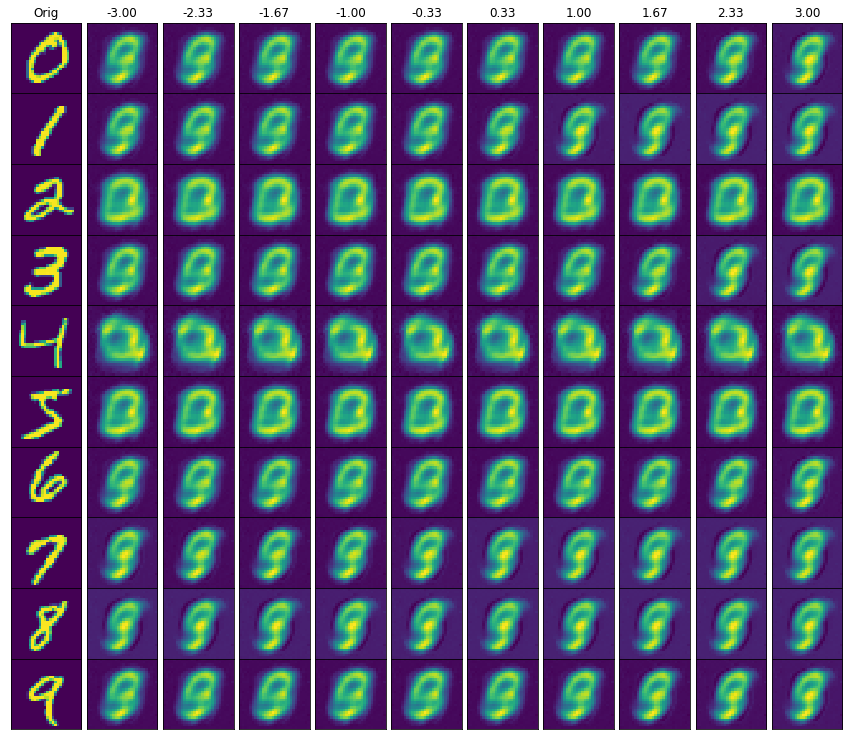

In [17]:
plot_digits(model)

## Gradient Clipping

In [6]:
%%time
model_a = MnistBetaTCVAE()
trainer = Trainer(max_epochs=10, gradient_clip_val=1.0)
trainer.fit(model_a)


CPU times: user 1h 23min 41s, sys: 5min 15s, total: 1h 28min 56s
Wall time: 9min 15s


1

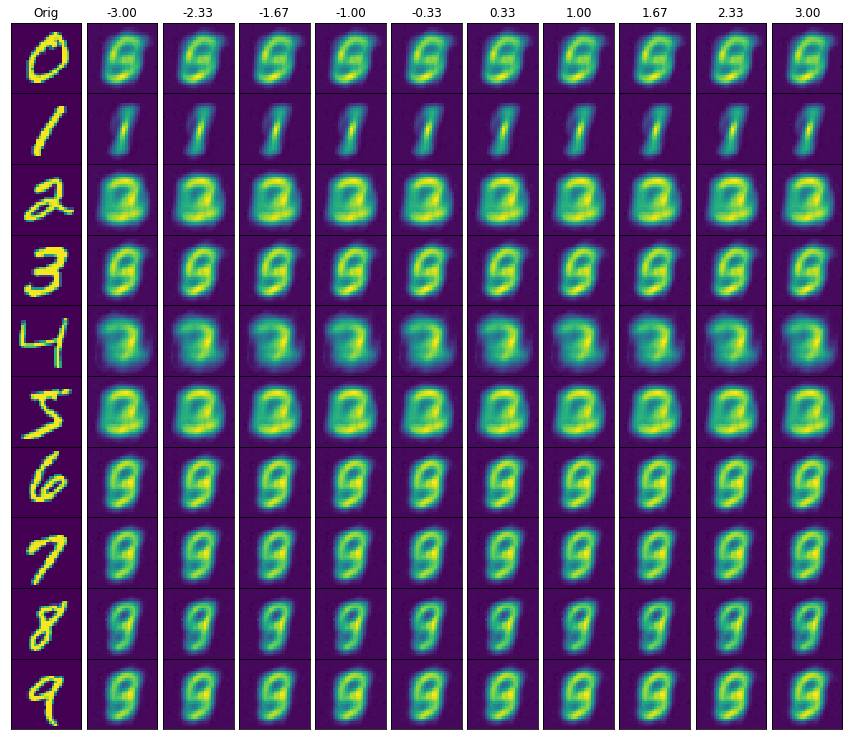

In [18]:
plot_digits(model_a)

## Lower Learning Rate

In [8]:
%%time
model_b = MnistBetaTCVAE(lr=0.0001)
trainer = Trainer(max_epochs=10)
trainer.fit(model_b)


CPU times: user 49min 13s, sys: 2min 19s, total: 51min 33s
Wall time: 5min 6s


1

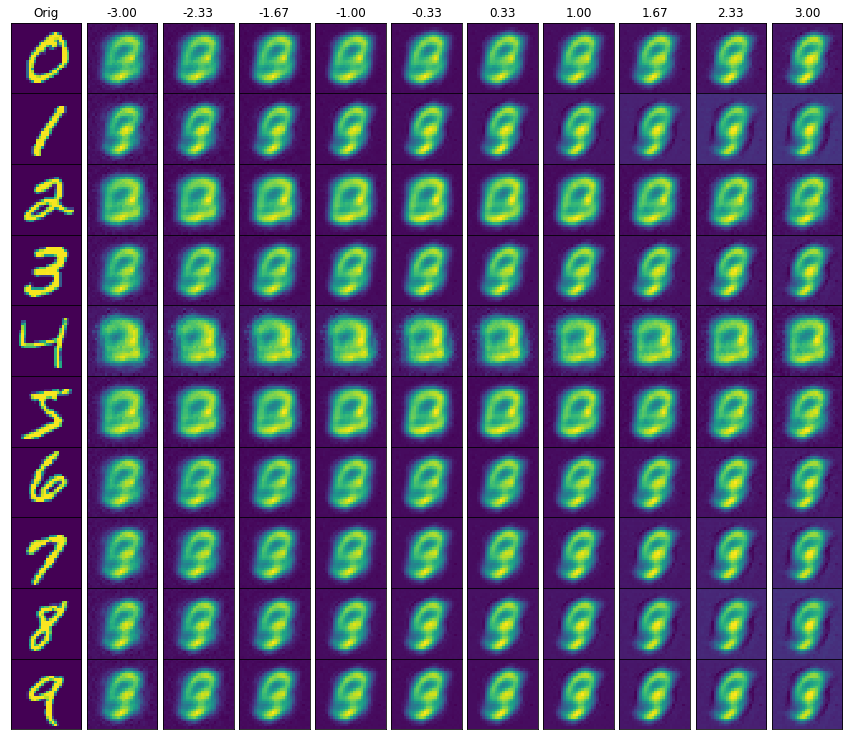

In [19]:
plot_digits(model_b)

## Smaller Networks

In [10]:
%%time
model_c = MnistBetaTCVAE(small=True)
trainer = Trainer(max_epochs=10)
trainer.fit(model_c)


CPU times: user 38min 49s, sys: 1min 30s, total: 40min 20s
Wall time: 3min 54s


1

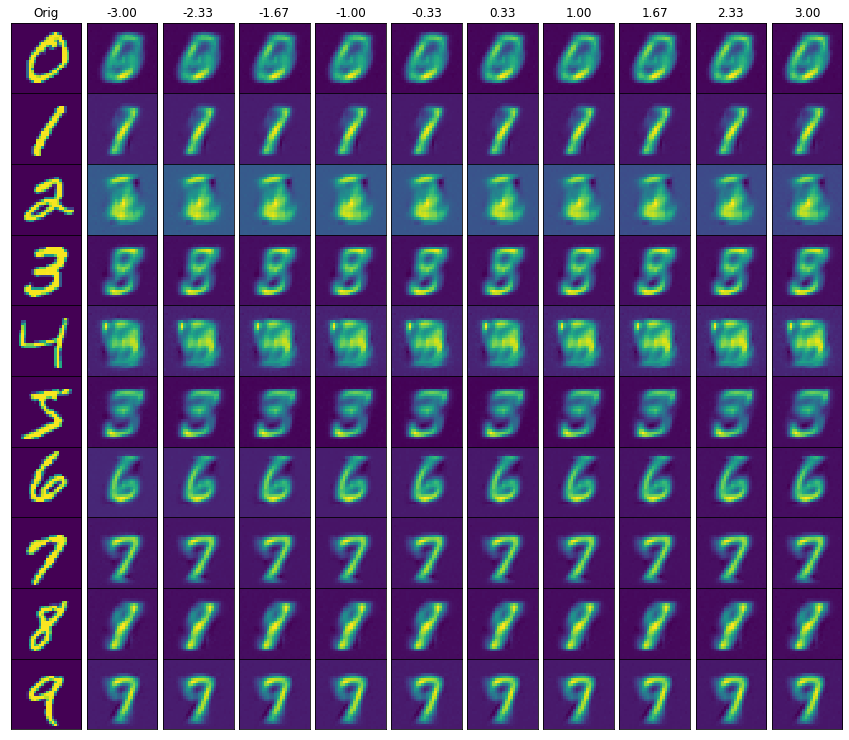

In [25]:
plot_digits(model_c, i=0)

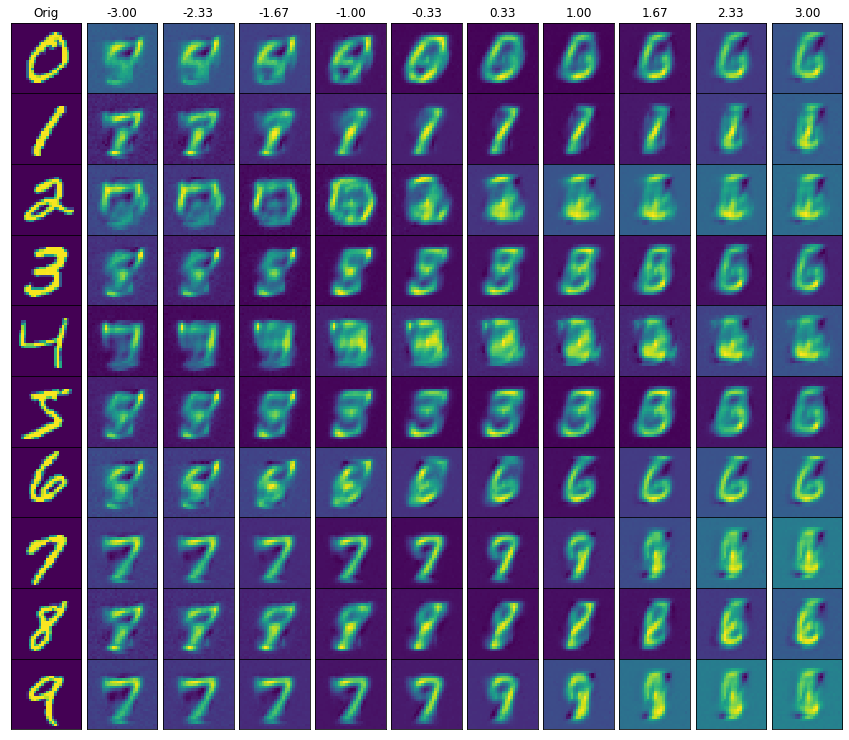

In [30]:
plot_digits(model_c, i=2)

## Both Gradient Clip and Lower LR

In [12]:
%%time
model_ab = MnistBetaTCVAE(lr=0.0001)
trainer = Trainer(max_epochs=10, gradient_clip_val=1.0)
trainer.fit(model_ab)


CPU times: user 1h 24min 10s, sys: 3min 21s, total: 1h 27min 31s
Wall time: 8min 31s


1

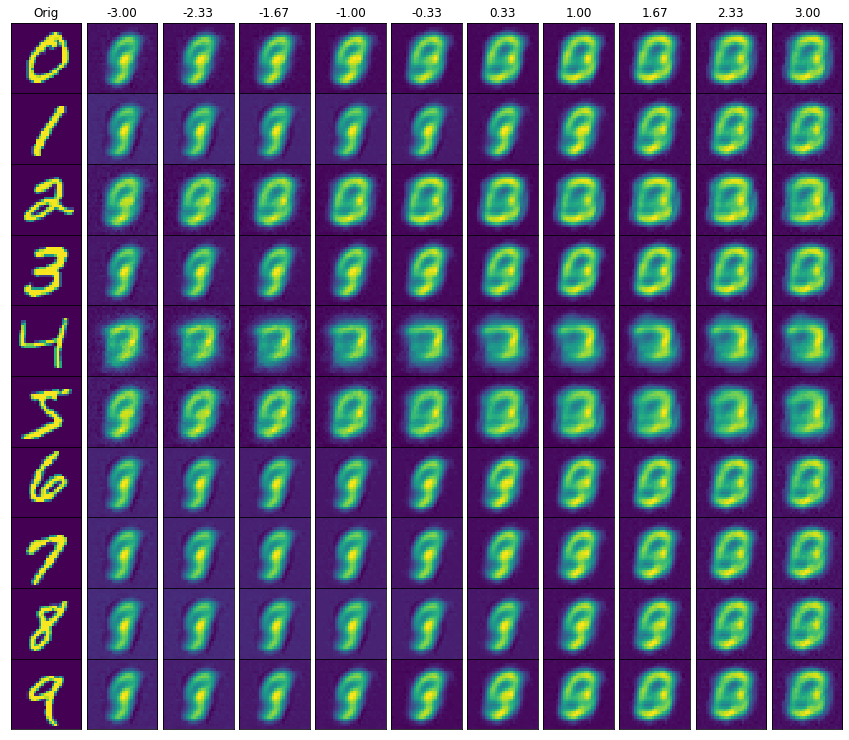

In [21]:
plot_digits(model_ab)

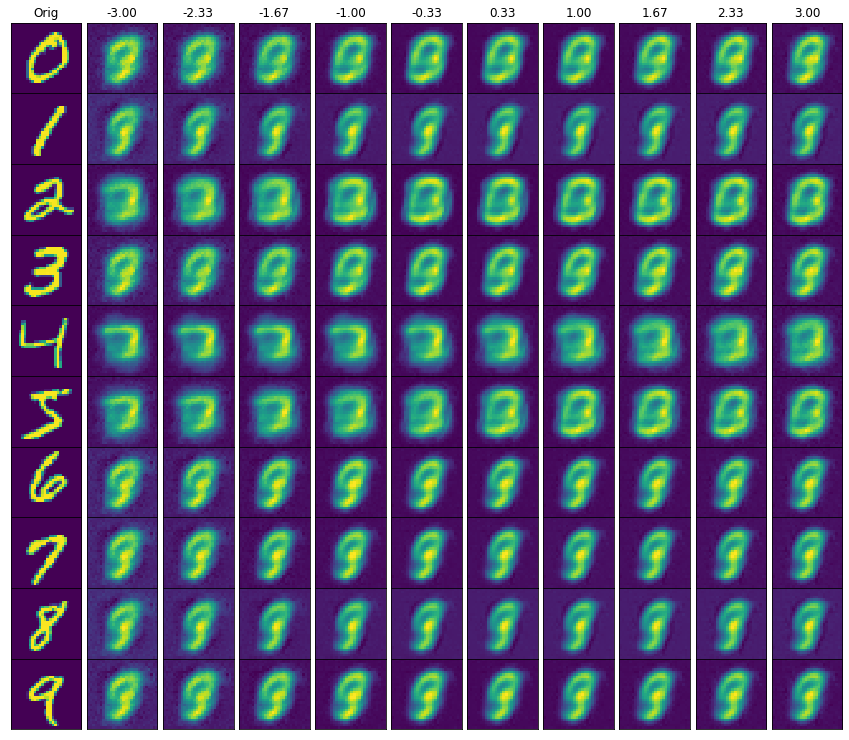

In [35]:
plot_digits(model_ab, i=3)

## Grad Clip, Lower LR, and Smaller Network

In [14]:
%%time
model_abc = MnistBetaTCVAE(lr=0.0001, small=True)
trainer = Trainer(max_epochs=10, gradient_clip_val=1.0)
trainer.fit(model_abc)


CPU times: user 51min 39s, sys: 2min 18s, total: 53min 57s
Wall time: 5min 19s


1

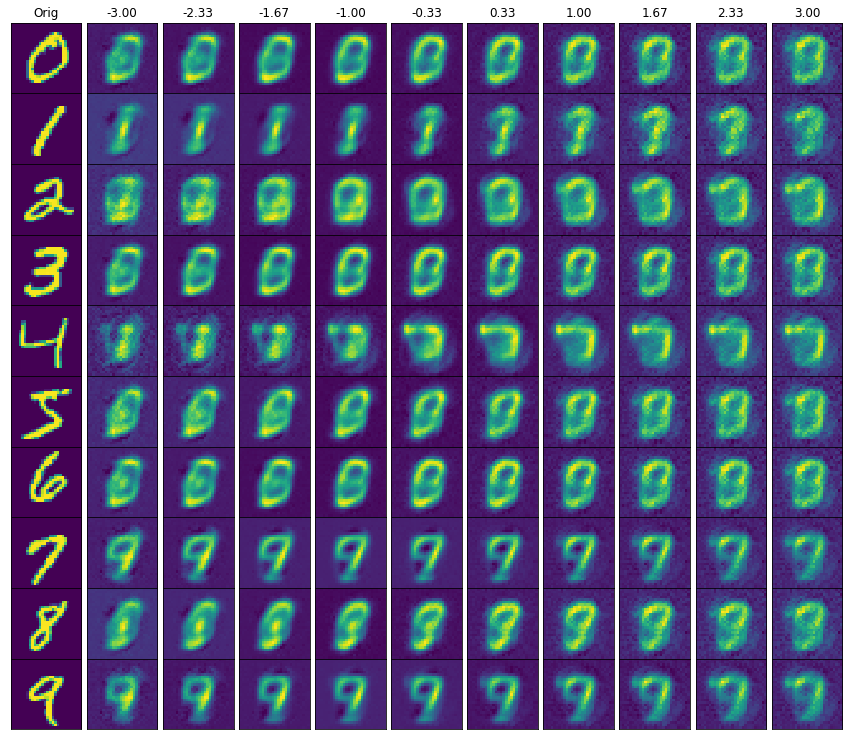

In [22]:
plot_digits(model_abc)

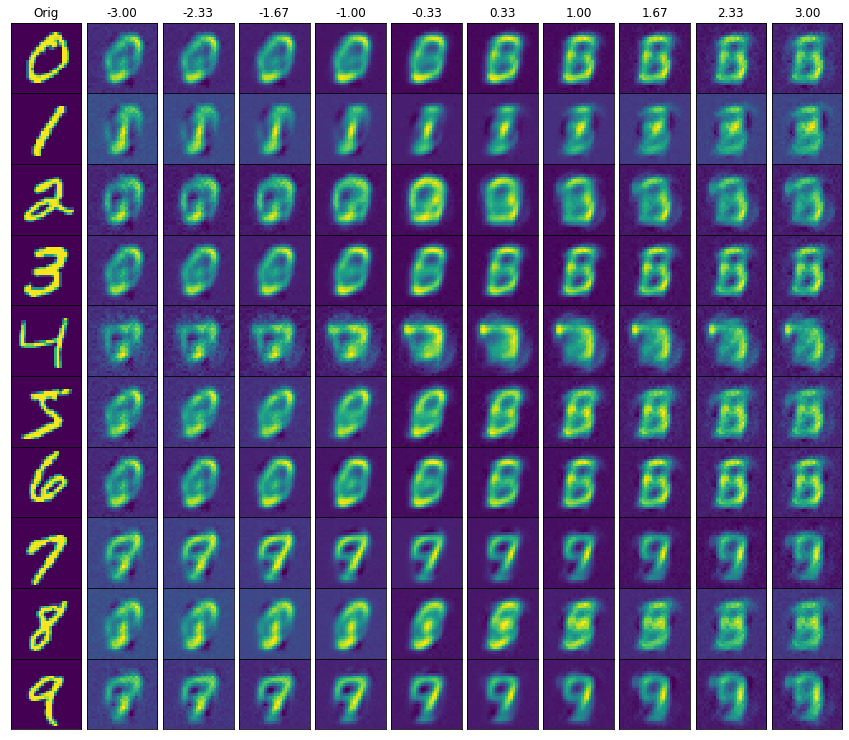

In [37]:
plot_digits(model_abc, i=10)